Here we will fit a discrete power law model:
$$
Pr(X = x | \alpha) = \frac{x^{-\alpha}}{\zeta(\alpha)},
$$
where $\zeta(s)$ is the [Riemann zeta function](https://en.wikipedia.org/wiki/Riemann_zeta_function).

In [1]:
source("../power_law_aux.r")
library(poweRlaw)
library(rstan)
library(bridgesampling)
rstan_options(auto_write = TRUE)

Loading required package: ggplot2
Loading required package: StanHeaders
rstan (Version 2.18.2, GitRev: 2e1f913d3ca3)
For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)


Stan requires the computation of gradients, and a naive sum would not give accurate results. Instead, we'll use an integral representation to compute the gradient of the normalising constant (Riemann's $\zeta$ function):
$$
\frac{d}{ds}\zeta(s) = \frac{1}{\Gamma(s)}\int_0^\infty \frac{x^{s-1}\left(\log(x) - \psi_0(s) \right)}{e^x -1}dx,
$$
where $\psi_0(\cdot)$ is the [digamma function](https://en.wikipedia.org/wiki/Digamma_function).
This can then be computed by standard quadrature.
Here's the C++ code to implement this, which we'll call using Rstan's ability to include header files:
`zeta.hpp`
```cpp
#include <boost/math/special_functions/zeta.hpp>
#include <boost/math/special_functions/digamma.hpp>
#include <boost/math/special_functions/gamma.hpp>
#include <boost/math/quadrature/exp_sinh.hpp>
using boost::math::isfinite;

inline double zeta(const double& s, std::ostream* pstream__){
  return boost::math::zeta(s);
}

inline var zeta(const var& s_var, std::ostream* pstream__) {
  double s = s_var.val();
  double f = zeta(s, pstream__);
  boost::math::quadrature::exp_sinh<double> integrator;
  auto int_rep_zeta_prime = [&](double x) {
    double ans = std::pow(x, s-1) *( std::log(x) - boost::math::digamma(s))/(std::exp(x) -1);
    if(!isfinite(ans)) return 0.0; // weird patching to get quadrature working
    return ans;
  };
  double tolerance = std::sqrt(std::numeric_limits<double>::epsilon());
  double error = 0.0;
  double L1 = 0.0;
  size_t levels;
  double deriv = integrator.integrate(int_rep_zeta_prime, tolerance, &error, &L1, &levels)/boost::math::tgamma(s);
  return var(new precomp_v_vari(f, s_var.vi_, deriv));
}
```

Here's the Stan code:

In [9]:
writeLines(readLines("../stan/discrete_power_law.stan"))

/*Assumes x_min = 1; if x_min > 1, we'd need a correction for that truncation*/
functions{
    real zeta(real s);
    /*TODO: implement rng for prior and posterior predictive checks*/
}
data{
  int<lower=0> K; // number of unique values
  int values[K];
  int<lower=0> frequencies[K];
  real<lower=0> alpha_shape;
  real<lower=0> alpha_rate;
}
parameters{
  real <lower=1> alpha;
}
model{
  real constant = log(zeta(alpha));
  for (k in 1:K) {
    target += frequencies[k] * (-alpha * log(values[k]) - constant);
  }
  target += gamma_lpdf(alpha |alpha_shape, alpha_rate);
} 


Now it's time to load the data and fit the model:

In [10]:
discplaw <- readRDS("../stan/discrete_power_law.rds")

In [6]:
data("moby")
the.data <- moby
cdata <- compress_data(the.data)
pl.data <- list(
  K = cdata$K,
  values = cdata$v,
  frequencies = cdata$fs,
  alpha_shape = 0.2,
  alpha_rate = 0.2  
)

In [11]:
posterior.discplaw <- sampling(discplaw, data = pl.data)
posterior.discplaw


SAMPLING FOR MODEL 'discrete_power_law' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000115 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 1.15 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.227867 seconds (Warm-up)
Chain 1:                0.217765 seconds (Sampling)
Chain 1:     

Inference for Stan model: discrete_power_law.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean   sd      2.5%       25%       50%       75%     97.5%
alpha      1.77    0.00 0.01      1.76      1.77      1.77      1.78      1.79
lp__  -40199.41    0.02 0.70 -40201.54 -40199.56 -40199.14 -40198.97 -40198.91
      n_eff Rhat
alpha  1415    1
lp__   1640    1

Samples were drawn using NUTS(diag_e) at Sun Feb 10 14:25:07 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

Now let's annotate the results and compare with maximum likelihood estimation (MLE).

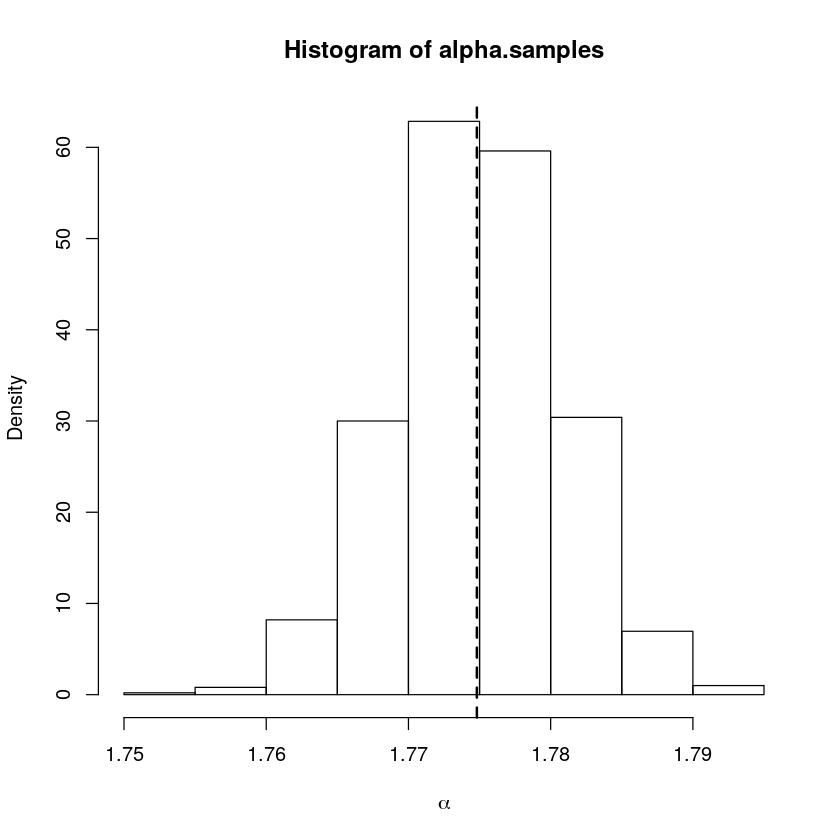

In [13]:
raw <- displ$new(the.data) 
raw$setXmin(1)
MLE <- estimate_pars(raw)

alpha.samples <- extract(posterior.discplaw, 'alpha')$alpha
hist(alpha.samples, probability = TRUE, xlab = expression(alpha))
abline(v = MLE$pars, lwd = 2, lty = 2)

In [14]:
bridgesampling::bridge_sampler(posterior.discplaw)

Warning message:
“effective sample size cannot be calculated, has been replaced by number of samples.”

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


Bridge sampling estimate of the log marginal likelihood: -40202.88
Estimate obtained in 4 iteration(s) via method "normal".